# BUSINESS PROBLEM

A retail company in the US wants to develop a marketing campaign. The company has data on their customers for about almoust 3 years, so they need to create a targeted ad marketing campaign by dividing their customers into at least 3 distinctive groups.

# IMPORT LIBRARIES AND DATASET



In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import plotly.express as px
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

In [4]:
# We load the dataset with pandas library
df = pd.read_csv('https://raw.githubusercontent.com/luisrrc/Unsupervised-learning-cases/main/sales_data_sample.csv', encoding = 'unicode_escape')

In [5]:
df

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,Motorcycles,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,Motorcycles,95,S10_1678,Corporate Gift Ideas Co.,6505551386,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,10350,20,100.00,15,2244.40,12/2/2004 0:00,Shipped,4,12,2004,Ships,54,S72_3212,Euro Shopping Channel,(91) 555 94 44,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Small
2819,10373,29,100.00,1,3978.51,1/31/2005 0:00,Shipped,1,1,2005,Ships,54,S72_3212,"Oulu Toy Supplies, Inc.",981-443655,Torikatu 38,NaN,Oulu,NaN,90110,Finland,EMEA,Koskitalo,Pirkko,Medium
2820,10386,43,100.00,4,5417.57,3/1/2005 0:00,Resolved,1,3,2005,Ships,54,S72_3212,Euro Shopping Channel,(91) 555 94 44,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Medium
2821,10397,34,62.24,1,2116.16,3/28/2005 0:00,Shipped,1,3,2005,Ships,54,S72_3212,Alpha Cognac,61.77.6555,1 rue Alsace-Lorraine,NaN,Toulouse,NaN,31000,France,EMEA,Roulet,Annette,Small


The Dataframe is made up of the following features:

**ORDERNUMBER** = identification of order placed.

**QUANTITYORDERD** = number of items ordered.

**PRICEEACH** = price of each item.

**MSRP** = is the manufacturer's suggested retail price (MSRP). 

**DEALSIZE** = size of the order.

**SALES** = total amount of sales.

**ORDERDATE** = date in which order is placed.

**STATUS** = status of the order.

**QTR_ID** = quarter in which order is placed.

**MONTH_ID** = month in which order is placed.

**YEAR_ID** = year in which order is placed.

**PRODUCTLINE** = product category.

**CUSTOMERNAME** = name of the customer.

**PHONE** = phone number.

**ADDRESSLINE1** = address to be shipped.

**ADDRESSLINE2** = address to be shipped.

**CITY** = city in which customer resides.

**STATE** = state in which customer resides.

**POSTALCODE** = postal code in which customer resides.

**COUNTRY** = country in which customer resides.

**TERRITORY** = territory in which customer resides.

**CONTACTFIRSTNAME** = contact person's first name.

**CONTACTLASTNAME** = contact person's last name.



In [6]:
# Let's view the types of data
df.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
PHONE                object
ADDRESSLINE1         object
ADDRESSLINE2         object
CITY                 object
STATE                object
POSTALCODE           object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

Let's convert order date to date format:

In [7]:
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

# Check the type of data
df.dtypes

ORDERNUMBER                  int64
QUANTITYORDERED              int64
PRICEEACH                  float64
ORDERLINENUMBER              int64
SALES                      float64
ORDERDATE           datetime64[ns]
STATUS                      object
QTR_ID                       int64
MONTH_ID                     int64
YEAR_ID                      int64
PRODUCTLINE                 object
MSRP                         int64
PRODUCTCODE                 object
CUSTOMERNAME                object
PHONE                       object
ADDRESSLINE1                object
ADDRESSLINE2                object
CITY                        object
STATE                       object
POSTALCODE                  object
COUNTRY                     object
TERRITORY                   object
CONTACTLASTNAME             object
CONTACTFIRSTNAME            object
DEALSIZE                    object
dtype: object

Searching for null values:

In [8]:
# Check the number of non-null values in the dataframe
df.info()

# Check the number of Null values in the data
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       2823 non-null   int64         
 1   QUANTITYORDERED   2823 non-null   int64         
 2   PRICEEACH         2823 non-null   float64       
 3   ORDERLINENUMBER   2823 non-null   int64         
 4   SALES             2823 non-null   float64       
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   STATUS            2823 non-null   object        
 7   QTR_ID            2823 non-null   int64         
 8   MONTH_ID          2823 non-null   int64         
 9   YEAR_ID           2823 non-null   int64         
 10  PRODUCTLINE       2823 non-null   object        
 11  MSRP              2823 non-null   int64         
 12  PRODUCTCODE       2823 non-null   object        
 13  CUSTOMERNAME      2823 non-null   object        
 14  PHONE             2823 n

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

Let's drop some columns that are not required for the analysis:

In [9]:
# since there are lot of Null values in 'addressline2', 'state', 'postal code' and 'territory' we can drop them. 
# Country would represent the order grographical information.
# Also we can drop city, address1, phone number, contact_name, contact last_name and contact first_name since they are not required for the analysis

df_drop = ['ADDRESSLINE1', 'ADDRESSLINE2', 'POSTALCODE', 'CITY', 'TERRITORY', 'PHONE', 'STATE', 'CONTACTFIRSTNAME', 'CONTACTLASTNAME', 'CUSTOMERNAME', 'ORDERNUMBER']
df = df.drop(df_drop, axis = 1)
df.head() 

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Motorcycles,95,S10_1678,USA,Small
1,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Motorcycles,95,S10_1678,France,Small
2,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,S10_1678,France,Medium
3,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,Motorcycles,95,S10_1678,USA,Medium
4,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,Motorcycles,95,S10_1678,USA,Medium


Let's check for null values again:

In [10]:
df.isnull().sum()

QUANTITYORDERED    0
PRICEEACH          0
ORDERLINENUMBER    0
SALES              0
ORDERDATE          0
STATUS             0
QTR_ID             0
MONTH_ID           0
YEAR_ID            0
PRODUCTLINE        0
MSRP               0
PRODUCTCODE        0
COUNTRY            0
DEALSIZE           0
dtype: int64

Obtain the number of unique values in each column:

In [11]:
df.nunique()

QUANTITYORDERED      58
PRICEEACH          1016
ORDERLINENUMBER      18
SALES              2763
ORDERDATE           252
STATUS                6
QTR_ID                4
MONTH_ID             12
YEAR_ID               3
PRODUCTLINE           7
MSRP                 80
PRODUCTCODE         109
COUNTRY              19
DEALSIZE              3
dtype: int64

# EXPLORATORY DATA ANALYSIS AND DATA CLEANING

Let's take a look at the country column:

In [12]:
df['COUNTRY'].value_counts().index

Index(['USA', 'Spain', 'France', 'Australia', 'UK', 'Italy', 'Finland',
       'Norway', 'Singapore', 'Canada', 'Denmark', 'Germany', 'Sweden',
       'Austria', 'Japan', 'Belgium', 'Switzerland', 'Philippines', 'Ireland'],
      dtype='object')

In [13]:
df['COUNTRY'].value_counts()

USA            1004
Spain           342
France          314
Australia       185
UK              144
Italy           113
Finland          92
Norway           85
Singapore        79
Canada           70
Denmark          63
Germany          62
Sweden           57
Austria          55
Japan            52
Belgium          33
Switzerland      31
Philippines      26
Ireland          16
Name: COUNTRY, dtype: int64

Let's visualize, but first we need to create a function to visualize the count of times in a given column:

In [14]:
def barplot_visualization(x):
  fig = plt.Figure(figsize = (12, 6))
  fig = px.bar(x = df[x].value_counts().index, y = df[x].value_counts(), color = df[x].value_counts().index, height = 600) 
  fig.show()

Let's call this function for any given column such as 'COUNTRY':

In [15]:
barplot_visualization('COUNTRY')

As we can see in the bar chart, most of our customers reside in the USA, following by Spain and France.

Now, let's call this function for the column 'STATUS':

In [16]:
barplot_visualization('STATUS')

We drop the column STATUS because its too imbalanced:

In [17]:
df.drop(columns = ['STATUS'], inplace = True)
df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,Motorcycles,95,S10_1678,USA,Small
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,Motorcycles,95,S10_1678,France,Small
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,Motorcycles,95,S10_1678,France,Medium
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,Motorcycles,95,S10_1678,USA,Medium
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,Motorcycles,95,S10_1678,USA,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,Ships,54,S72_3212,Spain,Small
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,Ships,54,S72_3212,Finland,Medium
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,Ships,54,S72_3212,Spain,Medium
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,Ships,54,S72_3212,France,Small


Let's visualize the column PRODUCTLINE:

In [18]:
 barplot_visualization('PRODUCTLINE')

Now, we'll do the same with the column 'DEALSIZE':

In [19]:
barplot_visualization('DEALSIZE')

Let's create a function to add dummy variables to replace categorical variables:

In [20]:
def dummies(x):
  dummy = pd.get_dummies(df[x])
  df.drop(columns = x, inplace = True)
  return pd.concat([df, dummy], axis = 1)

Let's obtain dummy variables for the column 'COUNTRY':

In [21]:
df = dummies('COUNTRY')
df.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,DEALSIZE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,Motorcycles,95,S10_1678,Small,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,Motorcycles,95,S10_1678,Small,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,Motorcycles,95,S10_1678,Medium,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,Motorcycles,95,S10_1678,Medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,Motorcycles,95,S10_1678,Medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Let's obtain dummies variable for the column 'PRODUCTLINE'

In [22]:

df = dummies('PRODUCTLINE')
df.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,DEALSIZE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,S10_1678,Small,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,S10_1678,Small,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,S10_1678,Medium,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,S10_1678,Medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,S10_1678,Medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


Let's obtain dummies variable for the column 'DEALSIZE'

In [23]:
df = dummies('DEALSIZE')
df.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,S10_1678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,S10_1678,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,S10_1678,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,S10_1678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,S10_1678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0


Now, let's convert the column 'PRODUCTCODE' to a categorical variable:

In [24]:
y = pd.Categorical(df['PRODUCTCODE'])
y

['S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', ..., 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212']
Length: 2823
Categories (109, object): ['S10_1678', 'S10_1949', 'S10_2016', 'S10_4698', ..., 'S700_3962',
                           'S700_4002', 'S72_1253', 'S72_3212']

In [25]:
y = pd.Categorical(df['PRODUCTCODE']).codes
y

array([  0,   0,   0, ..., 108, 108, 108], dtype=int8)

Since the number unique product code is 109, if we add one-hot variables, there would be additional 109 columns, we can avoid that by using categorical encoding. This is not the optimal way of dealing with it but it's important to avoid curse of dimensionality

In [26]:
df['PRODUCTCODE'] = pd.Categorical(df['PRODUCTCODE']).codes
df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,108,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,108,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


Now, let's group data by order date:

In [27]:
df_group = df.groupby(by = 'ORDERDATE').sum()
df_group

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
ORDERDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-01-06,151,288.78,10,12133.25,4,4,8012,363,174.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,4,0,2,2
2003-01-09,142,284.96,10,11432.34,4,4,8012,372,181.0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,2,2
2003-01-10,80,150.14,3,6864.05,2,2,4006,155,37.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,1,1
2003-01-29,541,1417.54,136,54702.00,16,16,32048,1695,723.0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,3,0,0,0,0,7,6,0,10,6
2003-01-31,443,1061.89,91,44621.96,13,13,26039,1365,720.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,7,0,0,0,2,4,0,0,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-05-13,259,561.18,21,31821.90,12,30,12030,728,101.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,6,0,0,0,0,0,2,3,1
2005-05-17,509,1269.43,105,59475.10,28,70,28070,1669,462.0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,2,8,4
2005-05-29,607,1148.40,94,51233.18,30,75,30075,1328,797.0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,7,0,0,0,0,0,8,0,8,7


Let's visualize in which month the sales generally peak:

In [28]:
fig = px.line(x = df_group.index, y = df_group.SALES, title = 'SALES')
fig.show()

We can see from the line graph, the peaks in sales are reached in the month of November.

Let's  drop 'ORDERDATE' and keep the rest of the date-related data such as 'MONTH':

In [29]:
df.drop(['ORDERDATE'], axis = 1, inplace = True)
df.shape

(2823, 38)

Let's visualize a correlation matrix between variables:

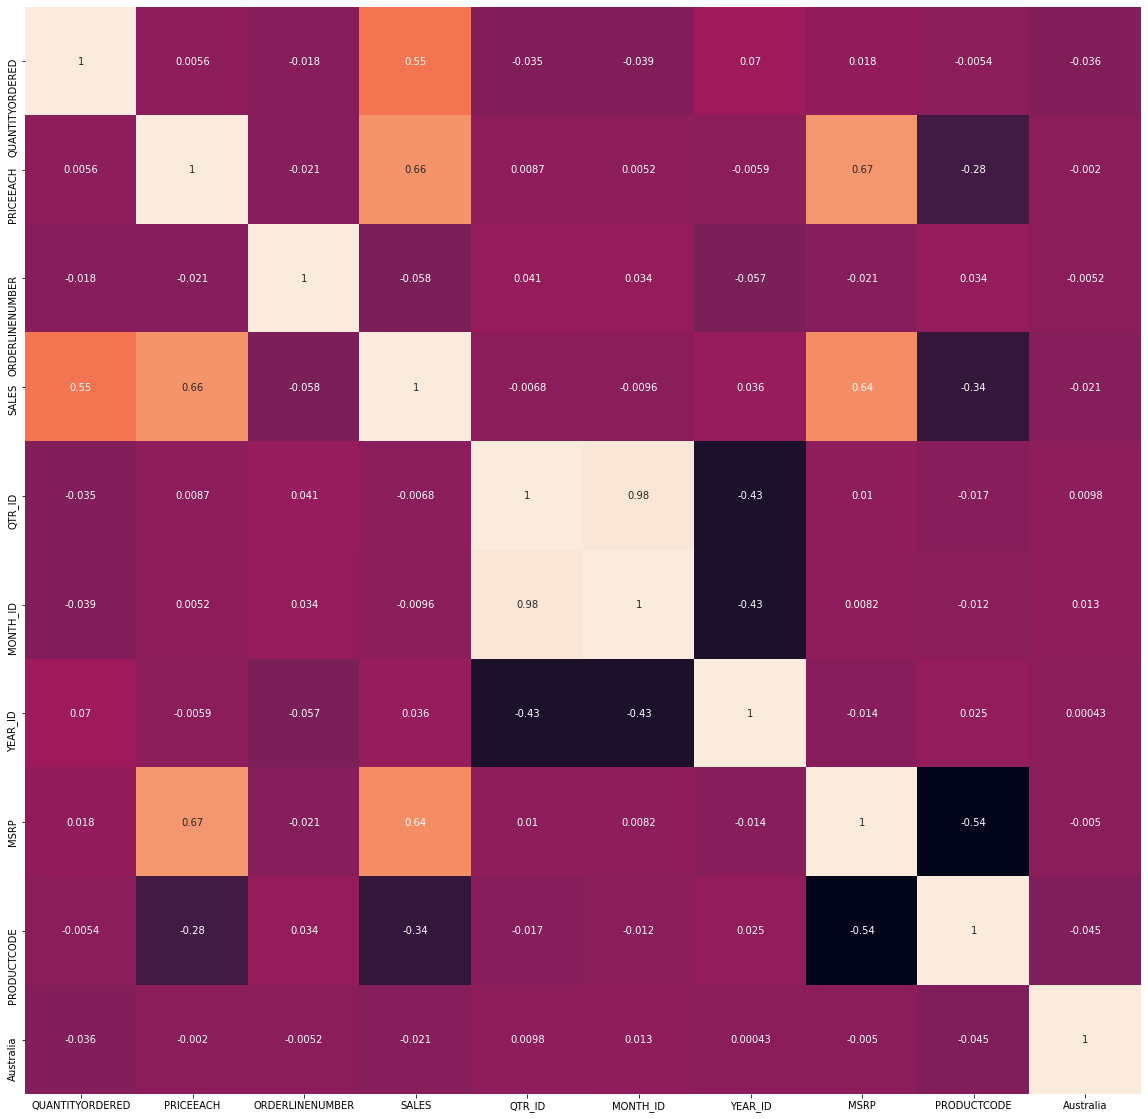

In [30]:
plt.figure(figsize = (20, 20))
corr_matrix = df.iloc[:, :10].corr()
sns.heatmap(corr_matrix, annot = True, cbar = False)

It looks like the Quarter ID and the monthly IDs are highly correlated.

Let's drop 'QTR_ID' (or 'MONTH_ID'): 

In [31]:
df.drop('QTR_ID', axis = 1, inplace = True)
df.shape


(2823, 37)

Plotting distplots:

In [32]:
import plotly.figure_factory as ff

plt.figure(figsize = (10, 10))

for i in range(8):
  if df.columns[i] != 'ORDERLINENUMBER':
    fig = ff.create_distplot([df[df.columns[i]].apply(lambda x: float(x))], ['distplot'])
    fig.update_layout(title_text = df.columns[i])
    fig.show()


<Figure size 720x720 with 0 Axes>

Visualize the relationship between variables using pairplots:

In [33]:
plt.figure(figsize = (15, 15))

fig = px.scatter_matrix(df, dimensions = df.columns[:8], color = 'MONTH_ID')
fig.update_layout(title = 'Sales Data', width = 1100, height = 1100) 
fig.show()

<Figure size 1080x1080 with 0 Axes>

We can see that: 
 
A trend exists between 'SALES' and 'QUANTITYORDERED'.  
A trend exists between 'MSRP' and 'PRICEEACH'  
A trend exists between 'PRICEEACH' and 'SALES'

# FIND THE OPTIMAL NUMBER OF CLUSTERS USING ELBOW METHOD

In [34]:
# Scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [35]:
df_scaled.shape

(2823, 37)

Now, let´s use the elbow method to find optimal number of K for clustering:

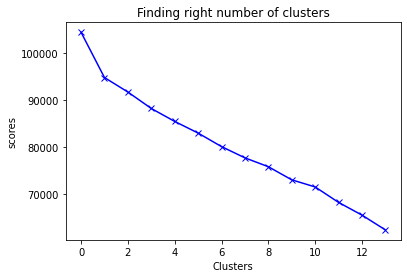

In [36]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(df_scaled)
  scores.append(kmeans.inertia_)

plt.plot(scores, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores')
plt.show()

As can be seen in the plot, it is not possible to determine an optimal value of K, therefore, the autoencoder technique should be applied. We pick the number 5 as the value of K.

# APPLY K-MEANS ALGORITHM

Let's cluster the data using k-means with the value of K = 5:

In [37]:
kmeans = KMeans(5)
kmeans.fit(df_scaled)
labels = kmeans.labels_

In [38]:
# kmeans cluster shape
kmeans.cluster_centers_.shape

(5, 37)

Let's take a look at the cluster centers: 

In [39]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [df.columns])
cluster_centers

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,-0.464258,-0.735121,0.036306,-0.813779,-0.014540,0.001377,-0.584145,0.283991,0.046027,-0.007873,0.031265,0.034109,-0.003910,0.009526,0.029172,0.009886,0.013604,-0.204199,0.037119,0.009730,-0.000133,0.017899,0.023337,-0.143553,-0.033164,0.030374,0.016842,-0.156247,0.038380,0.057446,0.063267,0.073804,-0.036634,0.062758,-0.242672,-0.980703,1.096370
1,1.264271,0.800092,-0.261504,2.581716,-0.085287,0.144435,1.412341,-0.861488,-0.082322,0.045752,-0.108756,-0.117969,0.110980,-0.001866,0.077142,0.026228,0.096382,0.026185,0.006951,0.012571,-0.028876,-0.013206,-0.035153,-0.143553,-0.105371,-0.114551,0.119599,0.569706,0.016566,-0.161898,-0.300637,-0.127846,-0.199144,-0.146484,4.120788,-0.980703,-0.912100
2,-0.238120,-0.111504,0.374193,-0.305340,0.129536,-0.099789,-0.205639,0.209124,-0.264819,-0.140961,-0.108756,-0.159458,-0.151083,-0.183541,-0.353765,-0.149852,-0.075499,4.897173,-0.136988,-0.176195,-0.096414,-0.169676,-0.371278,-0.143553,-0.105371,-0.231843,-0.742934,-0.304345,-0.305805,0.592055,-0.095340,0.006298,-0.284337,0.418106,-0.242672,-0.150357,0.262666
3,0.010285,0.152186,-0.131095,0.070903,0.473773,0.013539,0.101390,-0.164484,-0.264819,-0.140961,-0.108756,-0.159458,-0.151083,-0.183541,-0.353765,-0.149852,-0.075499,-0.204199,-0.136988,-0.176195,-0.096414,-0.169676,-0.371278,6.966083,-0.105371,-0.231843,-0.742934,-0.093345,-0.200857,-0.179374,0.335664,-0.059748,0.279807,-0.010937,-0.089568,0.107222,-0.066429
4,0.293311,0.579325,-0.026799,0.459464,-0.007736,-0.010869,0.378719,-0.167238,0.000670,0.019329,-0.002145,0.002661,0.009244,0.014372,0.008263,0.006522,-0.014441,-0.204199,-0.017680,0.011562,0.015547,0.006338,0.029073,-0.143553,0.055899,0.014682,0.062962,0.104010,-0.003519,-0.073449,-0.029103,-0.050203,0.067893,-0.073376,-0.242672,1.019676,-0.912100


Let's perform inverse transformation in order to understand what these numbers mean: 

In [40]:
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [df.columns])
cluster_centers

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30.571070,68.830627,6.619565,2055.283788,7.039298,2003.816054,77.244147,62.741639,7.692308e-02,1.839465e-02,1.505017e-02,3.010033e-02,2.173913e-02,3.428094e-02,1.204013e-01,2.341137e-02,6.688963e-03,-6.800116e-16,2.341137e-02,3.177258e-02,9.197324e-03,3.093645e-02,1.287625e-01,4.163336e-17,7.525084e-03,5.769231e-02,3.637124e-01,0.268395,0.129599,0.126254,1.003344e-01,0.039298,0.095318,0.240803,2.081668e-16,-1.054712e-15,1.000000e+00
1,47.406452,99.796968,5.361290,8308.219097,6.780645,2003.916129,157.464516,26.567742,4.516129e-02,2.580645e-02,-2.081668e-17,6.451613e-03,3.870968e-02,3.225806e-02,1.354839e-01,2.580645e-02,1.290323e-02,4.516129e-02,1.935484e-02,3.225806e-02,6.451613e-03,2.580645e-02,1.096774e-01,3.122502e-17,4.336809e-17,2.580645e-02,4.129032e-01,0.612903,0.122581,0.058065,-1.110223e-16,0.006452,0.045161,0.154839,1.000000e+00,-7.771561e-16,1.110223e-15
2,32.773585,81.409434,8.047170,2991.593208,7.566038,2003.745283,92.452830,60.377358,1.387779e-17,-3.469447e-17,-1.387779e-17,-3.816392e-17,1.387779e-17,6.938894e-18,9.714451e-17,4.857226e-17,1.040834e-17,1.000000e+00,3.122502e-17,7.632783e-17,-1.040834e-17,2.428613e-17,-2.081668e-16,-2.081668e-17,2.255141e-17,-5.551115e-17,0.000000e+00,0.198113,0.018868,0.292453,5.660377e-02,0.028302,0.018868,0.386792,-7.632783e-17,4.150943e-01,5.849057e-01
3,35.192982,86.728246,5.912281,3684.459825,8.824561,2003.824561,104.789474,48.578947,1.387779e-17,1.387779e-17,5.204170e-18,0.000000e+00,1.387779e-17,1.387779e-17,8.326673e-17,3.469447e-17,-1.734723e-18,-6.938894e-18,-2.081668e-17,2.081668e-17,-8.673617e-18,3.469447e-18,-4.163336e-17,1.000000e+00,-3.469447e-18,2.775558e-17,-1.665335e-16,0.298246,0.052632,0.052632,1.754386e-01,0.017544,0.192982,0.210526,3.508772e-02,5.438596e-01,4.210526e-01
4,37.949580,95.343927,6.352941,4400.009465,7.064171,2003.807487,115.932773,48.491979,6.569901e-02,2.215432e-02,1.145913e-02,2.521008e-02,2.368220e-02,3.514133e-02,1.138273e-01,2.291826e-02,4.583652e-03,-7.771561e-16,1.604278e-02,3.208556e-02,1.069519e-02,2.902979e-02,1.306341e-01,1.387779e-16,1.680672e-02,5.423988e-02,3.857907e-01,0.391902,0.116119,0.085561,7.486631e-02,0.019099,0.127578,0.184874,-2.567391e-16,1.000000e+00,-8.215650e-15


## Cluster 0  (Lowest) -  This group represents customers who buy items in low quantity ~30. They tend to buy low price items ~69. Their sales ~2055 is lower than other clusters and they are extremely active around holiday season. They buy products with low MSRP ~77.

## Cluster 1 - (Highest) - This group represents customers who buy items in high quantity centered around ~47, they buy items in all price range leaning towards high price items of ~100. They also correspond to the highest total sales around ~8308 and they are active throughout the year. They are the highest buyers of products with high MSRP ~157.

## Cluster 2 - This group represents customers who are only active during the holidays. they buy in lower quantity ~32, but they tend to buy average price items around ~81. They also correspond to lower total sales around ~2991, they tend to buy items with MSRP around 92.

## Cluster 3 - This group represents customers who buy items in varying quantity ~35, they tend to buy average price items ~86. Their sales ~3684 and the MSRP of ~105.

## Cluster 4 - This group represents customers who buy items in varying quantity ~38, they tend to buy high price items ~95. Their sales is bit better average ~4400, they buy products with second highest MSRP of ~116.

Labels associated to each data point:

In [41]:
labels.shape

(2823,)

Maximun numbers of labels:

In [42]:
labels.max()

4

Now, fit and predict with kmeans algortihm:

In [43]:
y_kmeans = kmeans.fit_predict(df_scaled)
y_kmeans

array([1, 1, 3, ..., 3, 1, 3], dtype=int32)

In [44]:
y_kmeans.shape

(2823,)

 Add a label (which cluster) corresponding to each data point:

In [45]:
df_cluster = pd.concat([df, pd.DataFrame({'cluster': labels})], axis = 1)
df_cluster

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,cluster
0,30,95.70,2,2871.00,2,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
1,34,81.35,5,2765.90,5,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,41,94.74,2,3884.34,7,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,4
3,45,83.26,6,3746.70,8,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,4
4,49,100.00,14,5205.27,10,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,12,2004,54,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2819,29,100.00,1,3978.51,1,2005,54,108,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,4
2820,43,100.00,4,5417.57,3,2005,54,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,4
2821,34,62.24,1,2116.16,3,2005,54,108,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [46]:
df['ORDERLINENUMBER'] = df['ORDERLINENUMBER'].apply(lambda x: float(x))

Plotting a histogram for each feature based on cluster: 

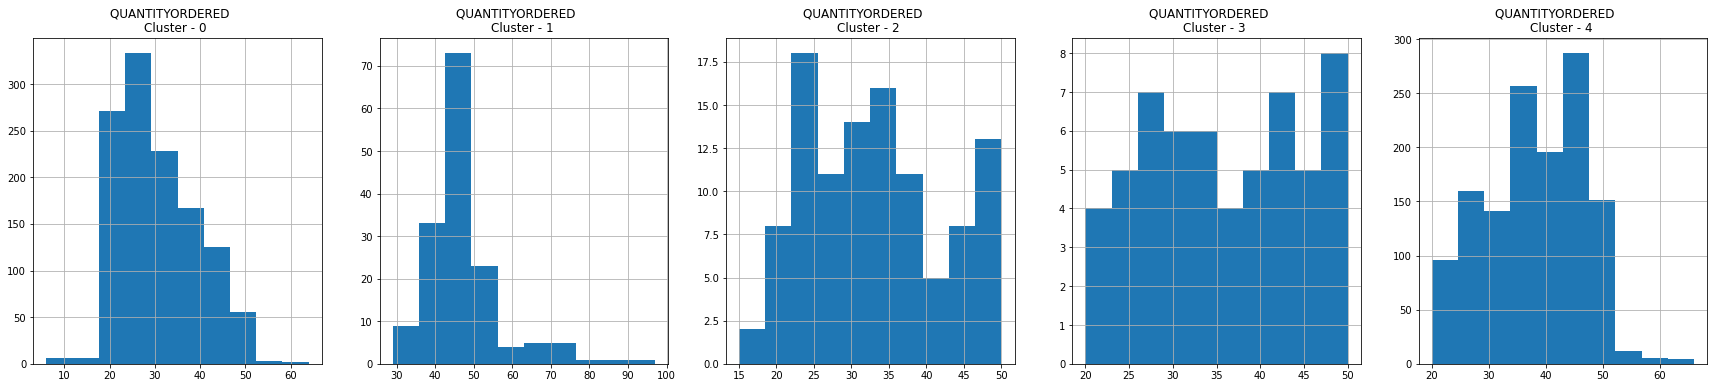

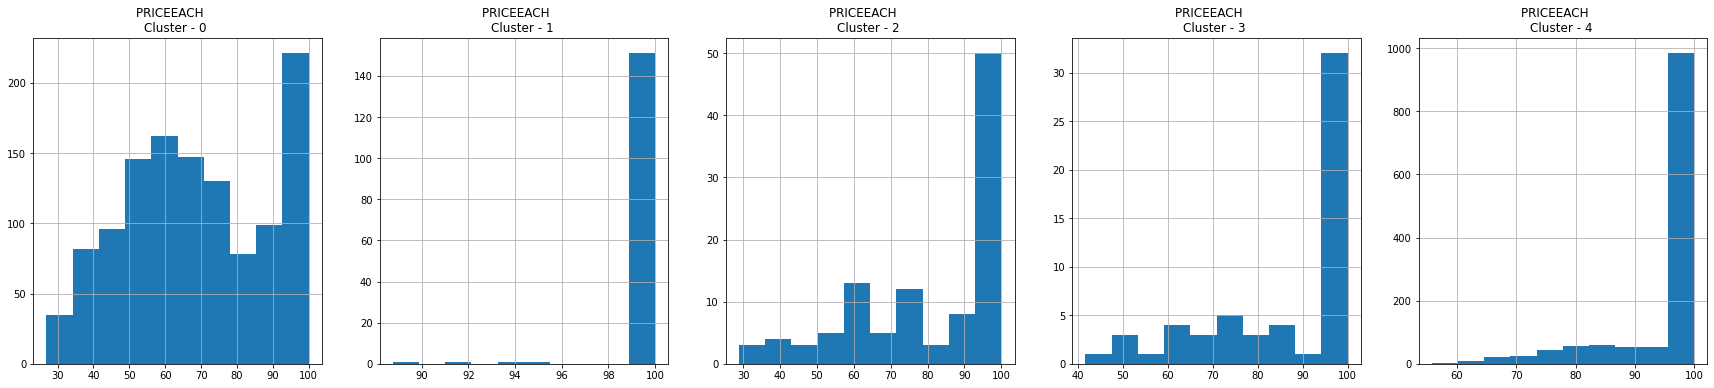

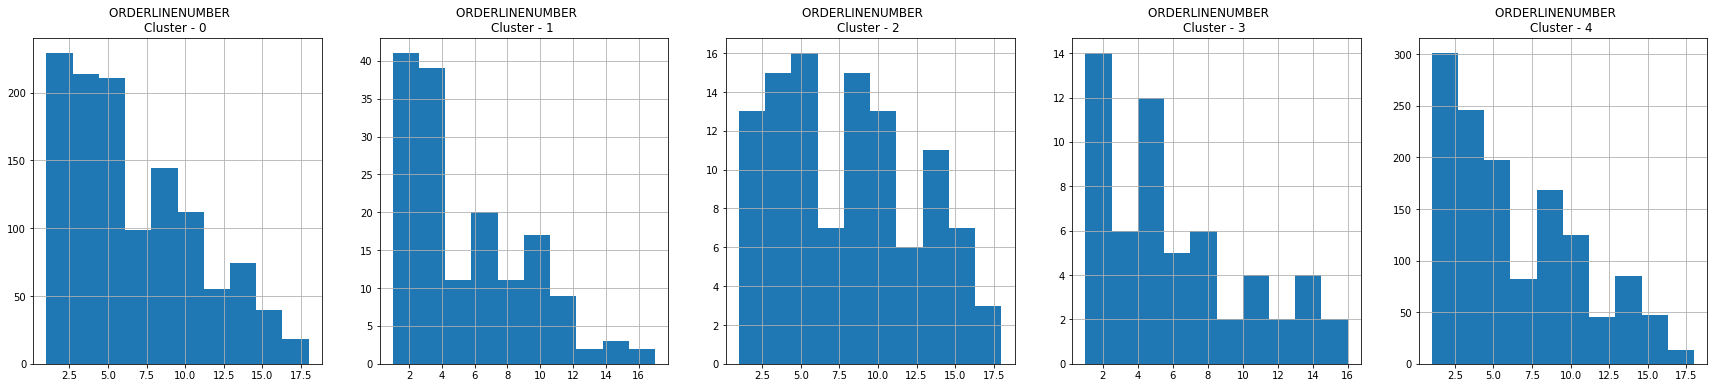

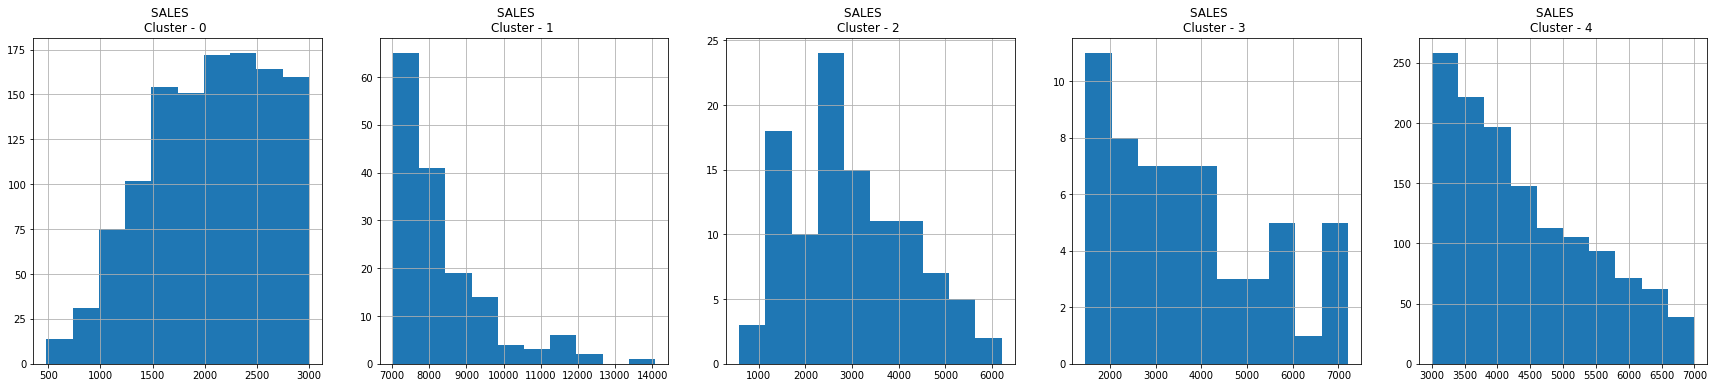

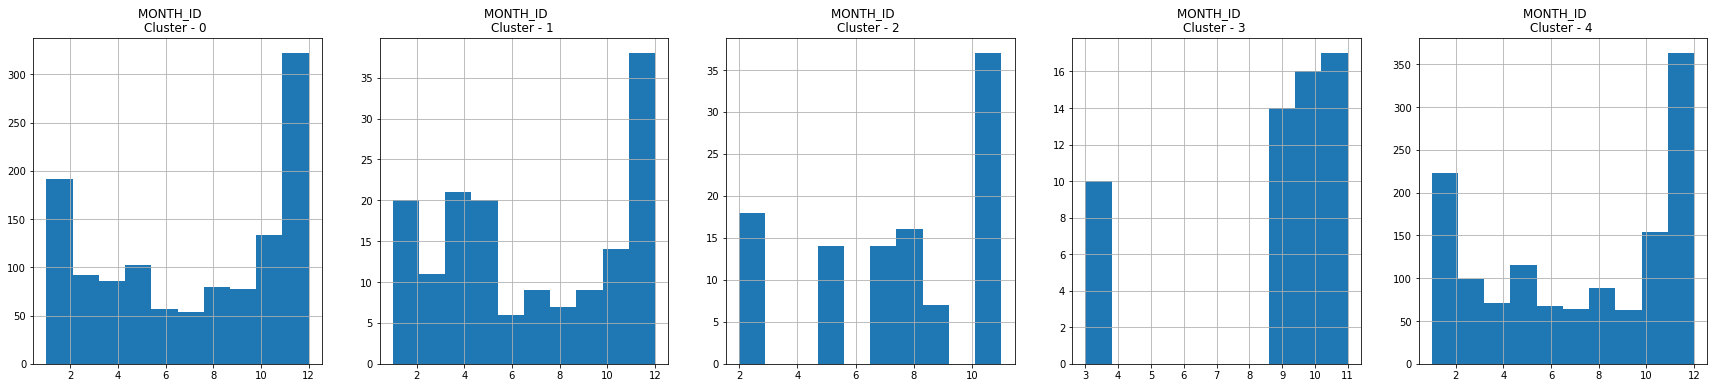

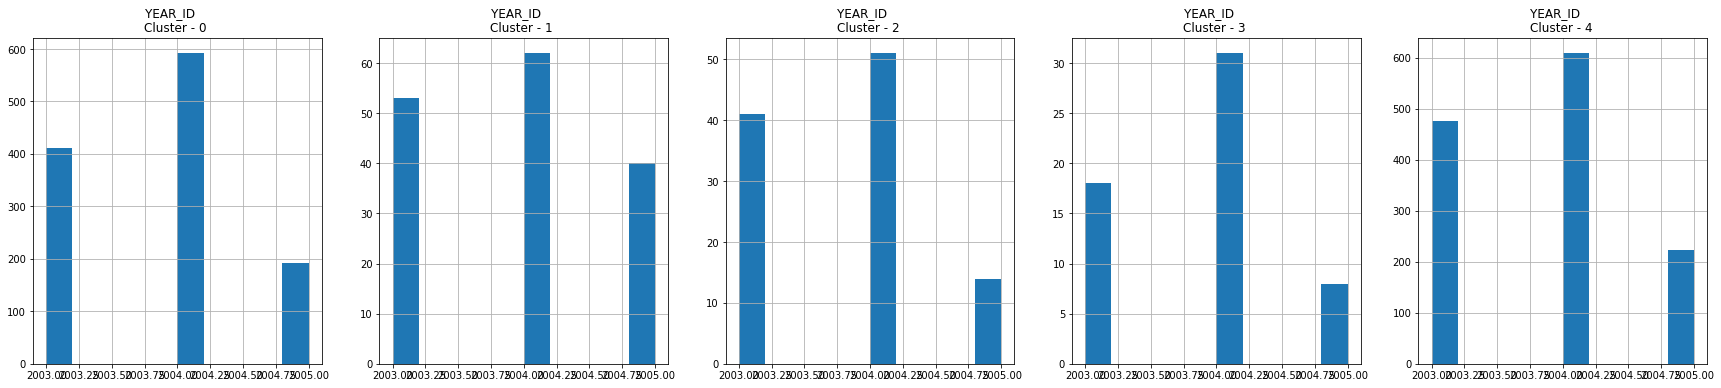

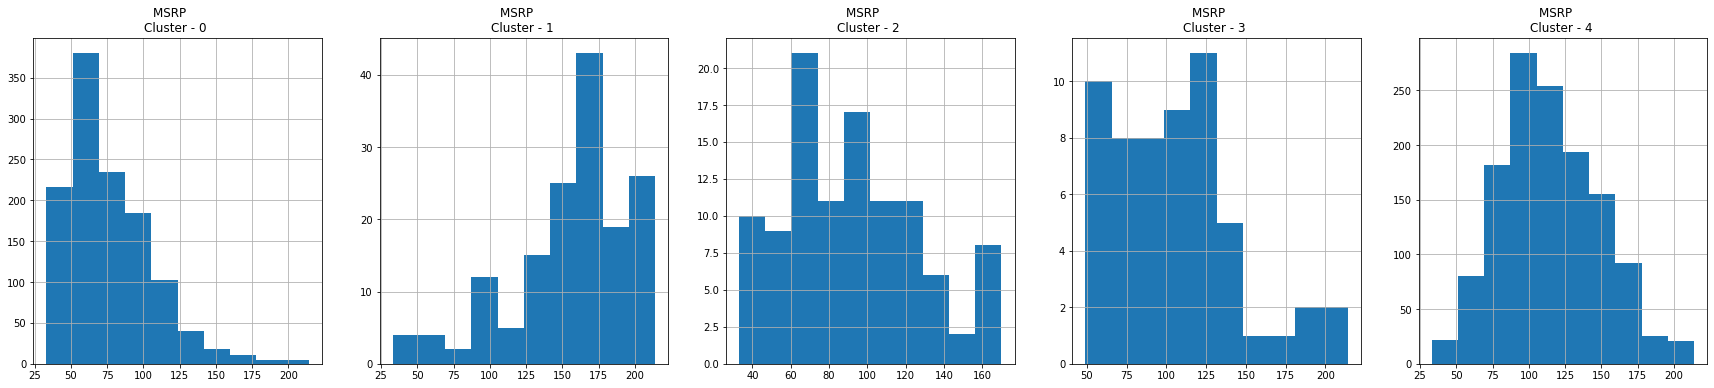

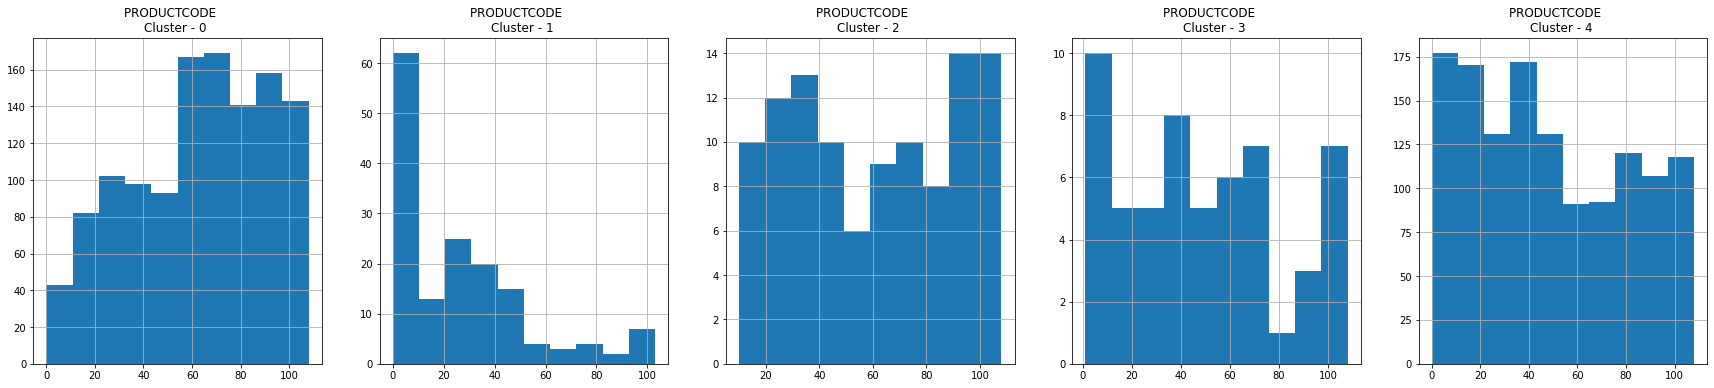

In [47]:
for i in df.columns[:8]:
  plt.figure(figsize = (30, 6)) 
  for j in range(5):
    plt.subplot(1, 5, j + 1)
    cluster = df_cluster[df_cluster['cluster'] == j]
    cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i, j))

  plt.show()

# APPLYING PRINCIPAL COMPONENT ANALYSIS AND VISUALIZE THE RESULTS

 Reduce the original data to 3 dimensions using PCA for visualizig the clusters:

In [48]:
pca = PCA(n_components = 3)
prin_comp = pca.fit_transform(df_scaled)
prin_comp

array([[-0.48628832, -1.19572684,  1.04028122],
       [-0.78462162, -1.00612883,  1.41377154],
       [ 1.4315162 ,  0.13924622,  0.26900159],
       ...,
       [ 0.38984712,  4.13236432, -0.06577298],
       [-2.78892927,  2.39413436,  1.50451413],
       [-0.70550513,  3.30281864, -0.54442824]])

Now, create a DataFrame with the pca columns:

In [49]:
pca_df = pd.DataFrame(data = prin_comp, columns = ['pca1', 'pca2', 'pca3']) 
pca_df.head()

,pca1,pca2,pca3
0,-0.486288,-1.195727,1.040281
1,-0.784622,-1.006129,1.413772
2,1.431516,0.139246,0.269002
3,1.288493,-0.218139,-0.560760
4,1.976099,-0.128417,-1.043290


Concatenate the clusters labels to the dataframe:

In [50]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster': labels})], axis = 1)
pca_df

,pca1,pca2,pca3,cluster
0,-0.486288,-1.195727,1.040281,0
1,-0.784622,-1.006129,1.413772,0
2,1.431516,0.139246,0.269002,4
3,1.288493,-0.218139,-0.560760,4
4,1.976099,-0.128417,-1.043290,4
...,...,...,...,...
2818,-2.450314,1.155844,-1.514651,0
2819,-0.158095,3.699686,0.598328,4
2820,0.389847,4.132364,-0.065773,4
2821,-2.788929,2.394134,1.504514,0


Visualize clusters using 3D-Scatterplot:

In [51]:
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3', color = 'cluster', symbol = 'cluster', size_max = 18, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))


# APPLY AUTOENCODERS

In [52]:
from keras.optimizers import SGD

# Glorot Uniform initializer:

input_df = Input(shape = 37,)
x = Dense(50, activation = 'relu')(input_df)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
encoded = Dense(8, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
decoded = Dense(37, kernel_initializer = 'glorot_uniform')(x)

# autoencoder
autoencoder = Model(input_df, decoded)

# encoder - used for dimensionality reduction
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

Running the autoencoder algorithm:

In [53]:
autoencoder.fit(df, df, batch_size = 128, epochs = 500, verbose = 3) 

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

Saving the weigths:

In [54]:
autoencoder.save_weights('autoencoder_1.h5')

Now, let's make the predictions:

In [55]:
pred = encoder.predict(df_scaled)

Now, Let´s doing again all the process of apply the elbow method and the k-means algortihm.

Finding the optimal number of clusters using the elbow method:

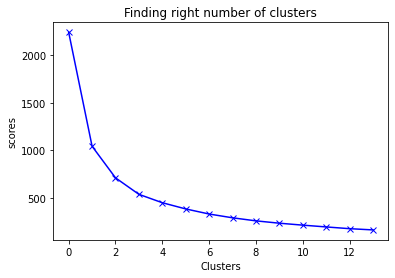

In [56]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(pred)
  scores.append(kmeans.inertia_)

plt.plot(scores, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores')
plt.show()

Apply the kmeans algorithm using the number of k = 3:

In [57]:
kmeans = KMeans(3)
kmeans.fit(pred)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(df_scaled)

Concatenate the clusters with the Dataframe:

In [58]:
df_cluster_dr = pd.concat([df, pd.DataFrame({'cluster': labels})], axis = 1)
df_cluster_dr.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,cluster
0,30,95.70,2.0,2871.00,2,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
1,34,81.35,5.0,2765.90,5,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2
2,41,94.74,2.0,3884.34,7,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,2
3,45,83.26,6.0,3746.70,8,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,2
4,49,100.00,14.0,5205.27,10,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0


Now, let´s do the same with the cluster_centers:

In [59]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [df.columns])
cluster_centers

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,-0.468912,-0.724370,0.043454,-0.810304,0.007142,-0.003285,-0.581757,0.285478,0.025174,-0.016801,0.021872,0.021124,-0.013783,-0.003425,0.003484,-0.000830,0.007626,0.042513,0.025440,-0.002742,-0.006592,0.005316,-0.003135,-0.010455,-0.038008,0.012783,-0.034126,-0.162957,0.013781,0.072858,0.058660,0.071986,-0.044714,0.087993,-0.242672,-0.980703,1.09637
1,0.293073,0.580208,-0.010805,0.458608,0.003368,-0.012482,0.376634,-0.165542,-0.013717,0.010642,-0.007922,-0.006125,0.000556,0.003647,-0.011355,-0.001952,-0.017750,-0.042017,-0.024145,0.001387,0.009480,-0.003200,0.007377,0.015695,0.047160,0.001323,0.019290,0.085141,-0.014094,-0.048853,-0.020232,-0.052121,0.064221,-0.064346,-0.242672,1.019676,-0.91210
2,1.245428,0.800220,-0.259579,2.573861,-0.088008,0.136857,1.430265,-0.871802,-0.084647,0.043374,-0.108756,-0.118498,0.107642,-0.004181,0.071653,0.023985,0.094193,0.023250,0.005118,0.010166,-0.029737,-0.015199,-0.039435,-0.052984,-0.105371,-0.116045,0.108611,0.580097,0.011712,-0.164278,-0.300637,-0.128350,-0.201008,-0.151285,4.120788,-0.980703,-0.91210


Using inver transform with the cluster centers:

In [60]:
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [df.columns])
cluster_centers

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30.525741,69.047496,6.649766,2061.682800,7.118565,2003.812793,77.340094,62.788612,0.071763,0.017161,1.404056e-02,0.028081,0.020281,0.031981,0.112324,0.021841,0.006240,0.048362,0.021841,0.029641,0.008580,0.028861,0.120125,0.018721,7.020281e-03,0.053822,0.339314,0.265211,0.121685,0.131045,9.906396e-02,0.039002,0.092824,0.251170,-1.595946e-16,-1.054712e-15,1.000000e+00
1,37.947254,95.361741,6.420520,4398.433699,7.104769,2003.806358,115.848988,48.545520,0.062139,0.020954,1.083815e-02,0.023844,0.022399,0.033237,0.107659,0.021676,0.004335,0.031792,0.015173,0.030347,0.010116,0.027457,0.123555,0.022399,1.589595e-02,0.051301,0.364884,0.382948,0.112717,0.093208,7.731214e-02,0.018786,0.126445,0.188584,-5.273559e-16,1.000000e+00,-8.715251e-15
2,47.222930,99.799554,5.369427,8293.753248,6.770701,2003.910828,158.184713,26.242038,0.044586,0.025478,-1.908196e-17,0.006369,0.038217,0.031847,0.133758,0.025478,0.012739,0.044586,0.019108,0.031847,0.006369,0.025478,0.108280,0.012739,4.336809e-17,0.025478,0.407643,0.617834,0.121019,0.057325,-1.110223e-16,0.006369,0.044586,0.152866,1.000000e+00,-7.771561e-16,9.992007e-16


 Plotting a histogram for each feature based on cluster: 

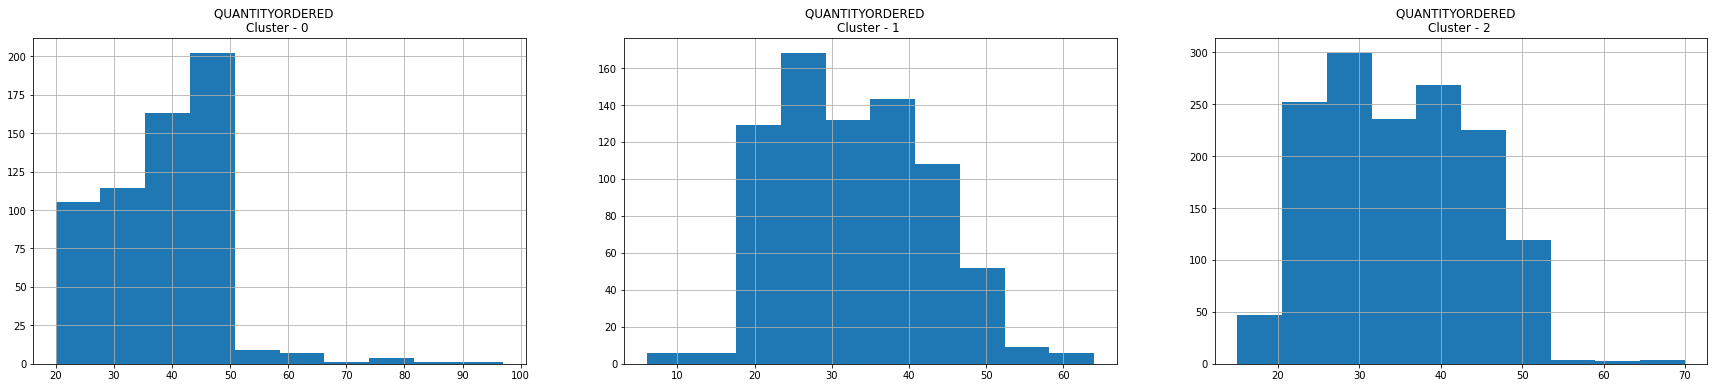

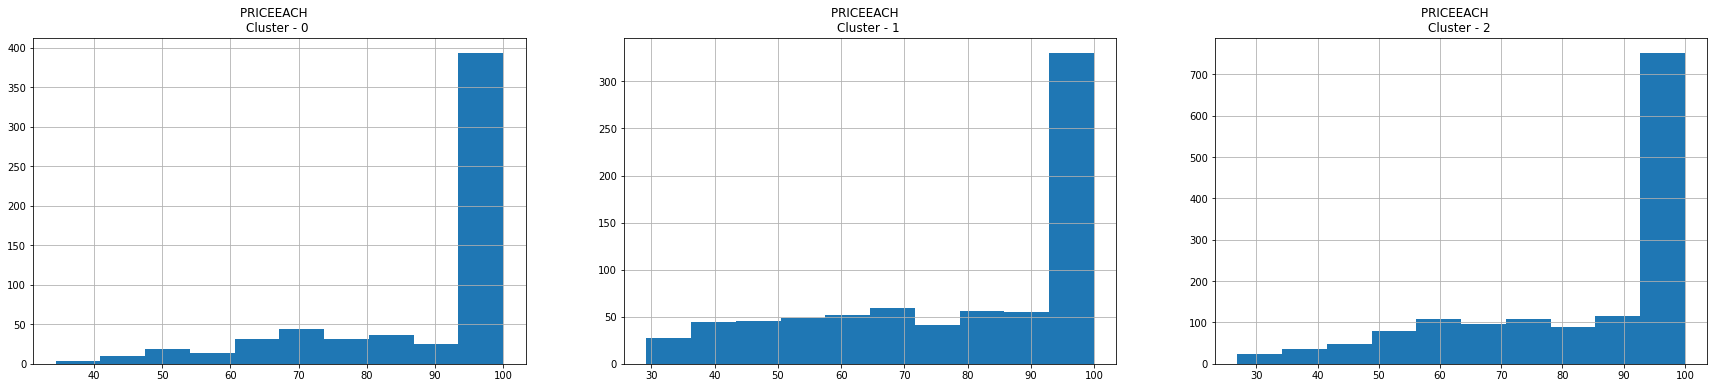

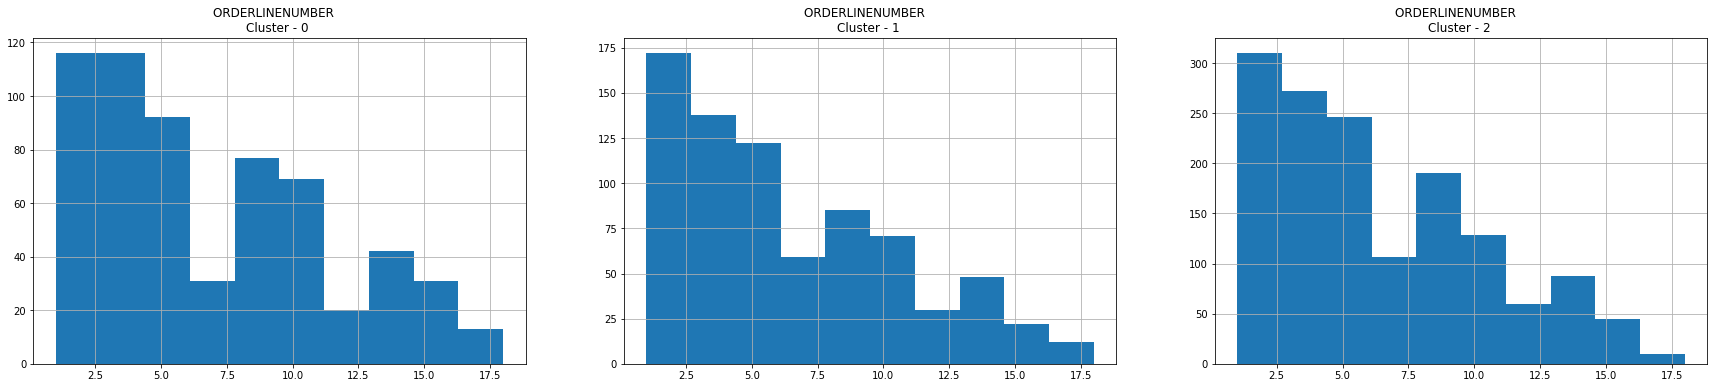

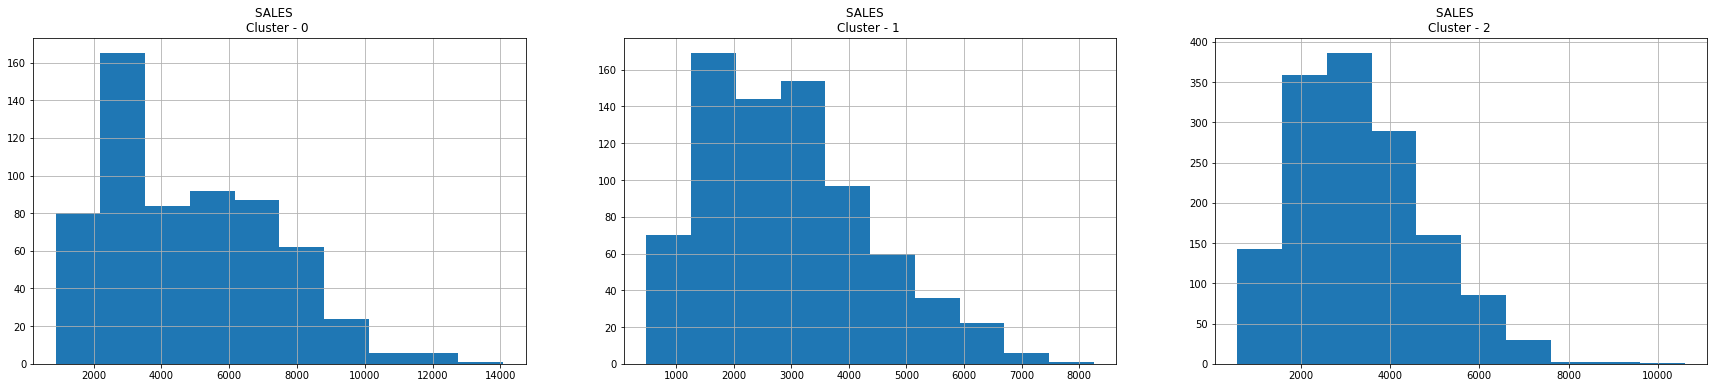

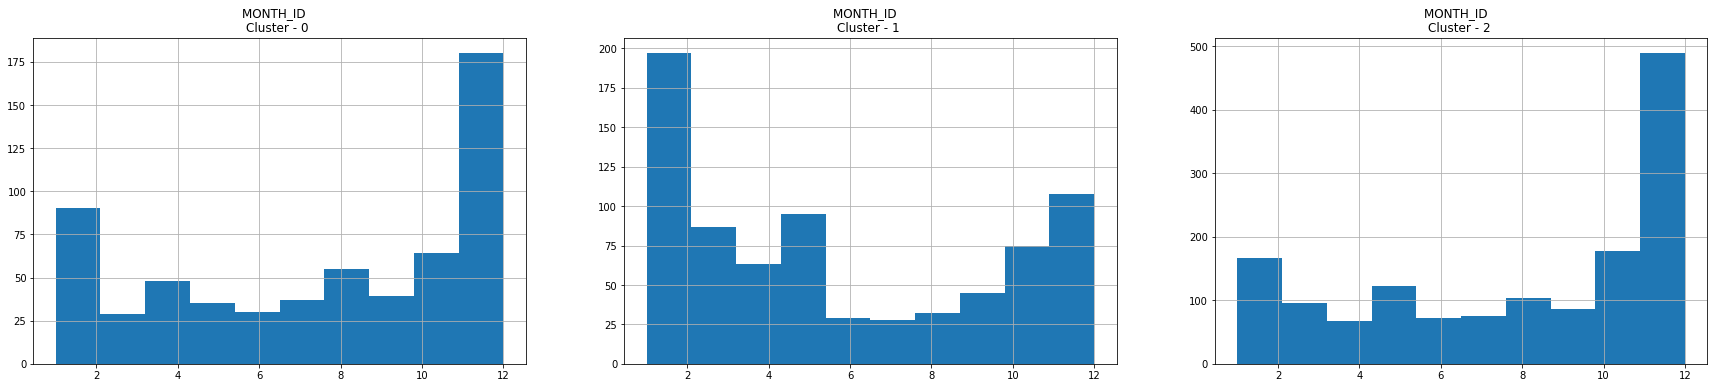

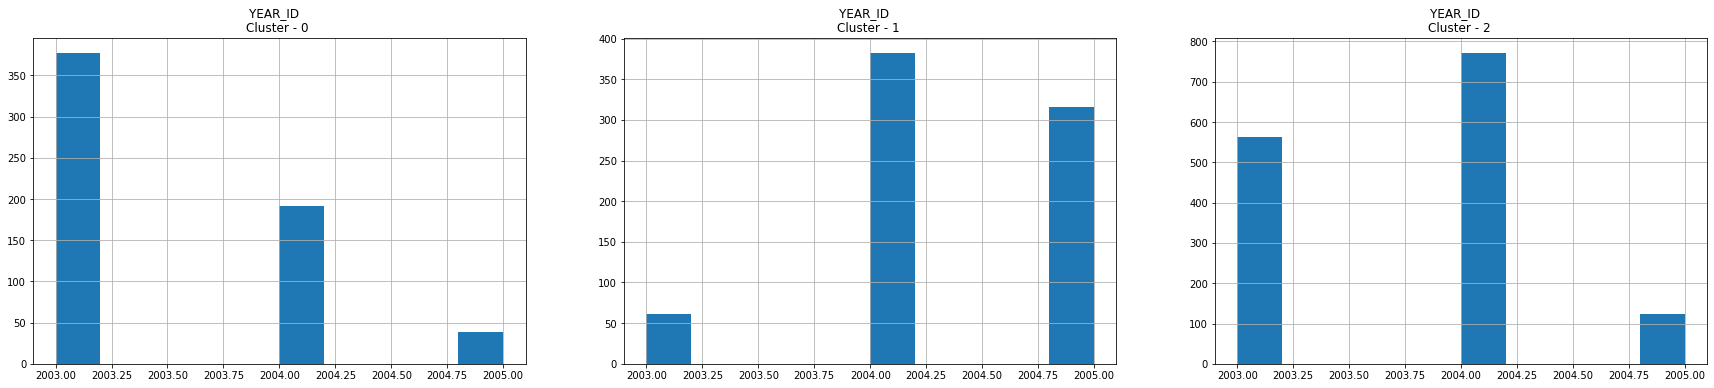

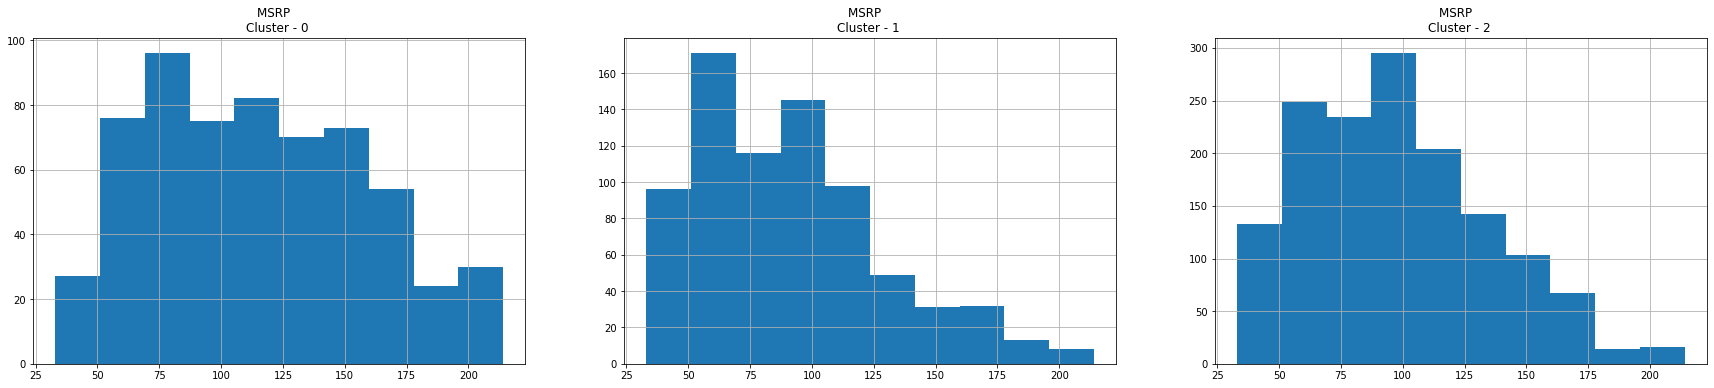

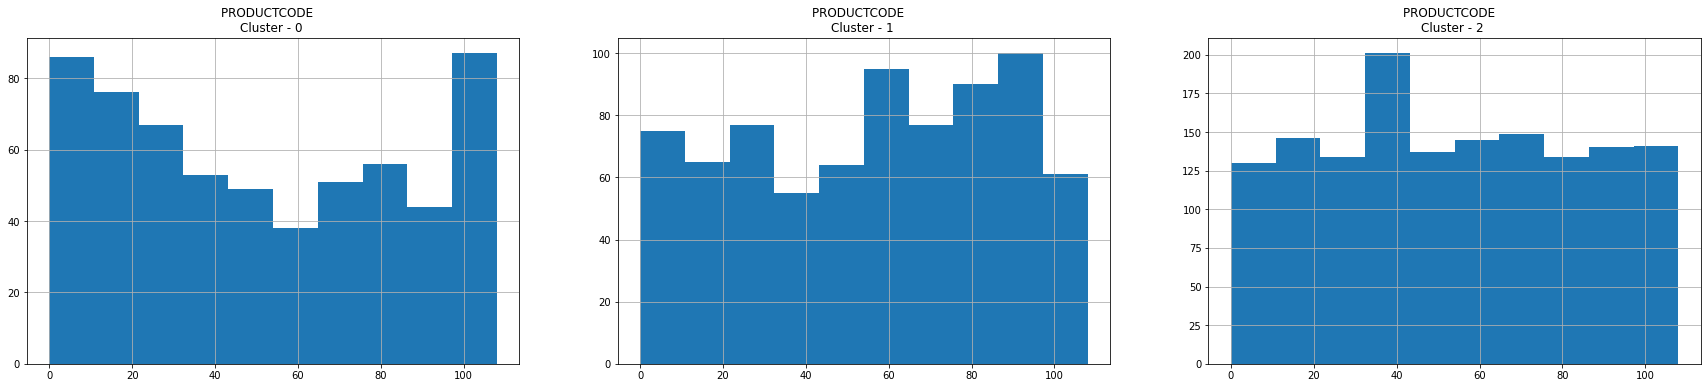

In [61]:
for i in df.columns[:8]:
  plt.figure(figsize =(30, 6))
  for j in range(3):
    plt.subplot(1, 3, j +1)
    cluster = df_cluster_dr[df_cluster_dr['cluster'] == j]
    cluster[i].hist()
    plt.title('{}   \nCluster - {} '.format(i, j))

  plt.show()

Cluster 0 - This group represents customers who buy items in small quantity(30) and they tend to buy low price items (69). They correspond to the lowest total sale(2055) . Also they then to buy products with low MSRP(76).

Cluster 1 - This group represents customers who buy items in high quantity(38), they buy tend to buy high price items(95). They bring-in average sales(4398).  Also they prefer to buy products with high MSRP(115) . 

Cluster 2 -  This group represents customers who buy items in high quantity(47), they usually buy items with high prices(100). They bring-in more sales than other clusters(8293) and they are active all around the year. They are mostly active through out the year. They buy products with high mrsp(158).

Let's reduce the original data to 3 dimension using PCA for visualize the clusters:

In [62]:
pca = PCA(n_components = 3)
princ_comp = pca.fit_transform(df_scaled)
pca_df = pd.DataFrame(data = princ_comp, columns = ['pca1', 'pca2', 'pca3'])  
pca_df.head()

,pca1,pca2,pca3
0,-0.486358,-1.180716,0.997711
1,-0.784751,-1.052413,1.446822
2,1.431296,0.084325,0.302233
3,1.288450,-0.202302,-0.577855
4,1.976203,-0.098034,-1.036667


Concatenate the pca with the dataframe:

In [63]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster': labels})], axis = 1)
pca_df.head()

,pca1,pca2,pca3,cluster
0,-0.486358,-1.180716,0.997711,0
1,-0.784751,-1.052413,1.446822,2
2,1.431296,0.084325,0.302233,2
3,1.288450,-0.202302,-0.577855,2
4,1.976203,-0.098034,-1.036667,0


Finally, visualize clusters using 3D-Scatterplot:

In [64]:
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3', color = 'cluster', symbol = 'cluster', size_max = 10, opacity = 0.7) 
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))